In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import product

### Helper Functions (from HW2)

In [2]:
def conv2(F, W, PAD, grey=False):
    '''
    Computes the 2D convolution of a kernel with an image. Automatically pads
    accoriding to the kernel dimensions to maintain the original images size.
    If the image is 3D, computes the 2D convolution accross each channel seperately.

    Args:
        F: image to filter/convolute, specified as either
             - a string containing the path to the image
             - a np.ndarrary
        W: kernel to convolute across image
             - np.ndarray of 2D filter weights
        PAD: padding type to be applied to image.
             - Clip: zero padding
             - wrap: wraps the opposite edge over
             - edge: copies the edge pixels
             - reflect: refelcts the pixels across the edge
        grey: Specifies if F is to be read as a greyscale image
             - Default value is False
             - Pass true to return a greyscale image
    '''
######################## Preprocessing ########################
    # Check if image or debug array
    image = False
    if isinstance(F, str):
        if grey: F = cv2.imread(F, cv2.IMREAD_GRAYSCALE)
        else: F = cv2.imread(F)
        image = True

    # Get image basics
    FSize = F.shape
    RGB = False
    if F.ndim > 2:
        RGB = True
        
    if W.ndim == 1:
        W = W.reshape(1,W.shape[0])
    if W.ndim > 2:
        WRows = W.shape[1]
        WColumns = W.shape[2]
    else:
        WRows = W.shape[0]
        WColumns = W.shape[1]

    # Create kernel class
    class KernelObj():
        def __init__(self, W):
            self.rDim = WRows
            self. cDim = WColumns
            self.weights = W.flatten()
            self.padSizes()
            self.setRefPix()
            self.pixels = list(product(range(0,self.rDim), range(0,self.cDim)))

        # Get padding dimensions
        def padSizes(self):
            # Image padding & set refpix
            self.rPadBSize = int(np.floor(self.rDim / 2)) # padding width on rows
            self.cPadRSize = int(np.floor(self.cDim / 2)) # padding width on columns
            if self.rDim % 2 == 0: # if rows even
                self.rPadTSize = int(self.rDim/2 - 1)
            else: # if rows odd
                self.rPadTSize = self.rPadBSize
            if self.cDim % 2 == 0: # if columns even
                self.cPadLSize = int(self.cDim/2 - 1)
            else: # if columns odd
                self.cPadLSize = self.cPadRSize
        
        # Set starting reference pixel coordinate
        def setRefPix(self):
            if self.rDim % 2 == 0: # if rows even
                refpixR = int(self.cDim/2 - 1)
            else: # if rows odd
                refpixR = int((self.cDim + 1)/2 - 1)
            if self.cDim % 2 == 0: # if columns even
                refpixC = int(self.cDim/2 - 1)
            else: # if columns odd
                refpixC = int((self.cDim + 1)/2 - 1)
            self.refpix = (refpixR, refpixC)

        # Slides kernel 1 column to the right
        def slide(self):
            self.refpix = (self.refpix[0], self.refpix[1] + 1)
            self.pixels = [(pixel[0], pixel[1] + 1) for pixel in self.pixels]

        # Moves kernel to next row down
        def nextrow(self,i):
            # Reset refpix and pixels
            self.setRefPix()
            self.refpix = (self.refpix[0] + i, self.refpix[1])
            self.pixels = list(product(range(i, self.rDim + i), range(0, self.cDim)))

    # Create kernel instance    
    kernel = KernelObj(W)

######################## Pad image ########################
    match PAD:
        case 'clip':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='constant', constant_values=0)
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='constant', constant_values=0)
        case 'wrap':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='wrap')
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='wrap')
        case 'edge':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='edge')
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='edge')
        case 'reflect':
            if RGB:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize), (0,0)), mode='symmetric')
            else:
                paddedF = np.pad(F, ((kernel.rPadTSize, kernel.rPadBSize), (kernel.cPadLSize, kernel.cPadRSize)), mode='symmetric')

######################## Convolution ########################
    # Output of convolution
    outputF = np.zeros(FSize)

    if RGB:
        channels = 3
        # Iterate through original F size but operate on paddedF
        for row in range(FSize[0]):
            for column in range(FSize[1]):
                for channel in range(0,channels):
                    singleChannelPaddedF = paddedF[:,:,channel]
                    # Convolve kernel with windowed pixels in paddedF
                    rPixels, cPixels = zip(*kernel.pixels)
                    windowedPixels = singleChannelPaddedF[rPixels, cPixels]
                    #windowedPixels = windowedPixels.reshape(kernel.rDim, kernel.cDim)
                    convOutput = np.sum((kernel.weights * windowedPixels), axis=None)
                    # Store output in resulting image
                    outputF[row, column, channel] = convOutput
                    
                # Slide the kernel one column to the right
                kernel.slide()
            # Move kernel onto next row
            kernel.nextrow(row + 1)
    else:
        for row in range(FSize[0]):
            for column in range(FSize[1]):
                # Convolve kernel with windowed pixels in paddedF
                rPixels, cPixels = zip(*kernel.pixels)
                windowedPixels = paddedF[rPixels, cPixels]
                convOutput = np.sum((kernel.weights * windowedPixels), axis=None)
                # Store output in resulting image
                outputF[row,column] = convOutput

                # Slide the kernel one column to the right
                kernel.slide()
            # Move kernel onto next row
            kernel.nextrow(row + 1)

    # Normalize and convert    min = np.min(outputF)
    min = np.min(outputF)
    # max = np.max(outputF)
    outputF = (outputF - min) / (255 - min) * 255
    outputF = outputF.astype(np.uint8)
    
    #if image: outputF = Image.fromarray(outputF)
    if image and RGB: 
        outputF = cv2.cvtColor(outputF, cv2.COLOR_BGR2RGB)
        paddedF = cv2.cvtColor(paddedF, cv2.COLOR_BGR2RGB)

    return outputF, paddedF

def upsample(IMAGE, SCALE):
    # Create upscaled image
    grey = False
    if len(IMAGE.shape) == 2:
        grey = True
        IMAGE = np.expand_dims(IMAGE, axis=2)
    upscaled_size = (IMAGE.shape[0]*SCALE, IMAGE.shape[1]*SCALE, IMAGE.shape[2])
    upscaled_image = np.zeros(upscaled_size)

    # Loop through every pixel in each channel
    for idx, channel in enumerate(upscaled_image.transpose(2, 0, 1)):
        for r in range(upscaled_size[0]):
            for c in range(upscaled_size[1]):
                # Find nearest neighbor coordinates
                original_r = min(r // SCALE, IMAGE.shape[0] - 1)
                original_c = min(c // SCALE, IMAGE.shape[1] - 1)

                # Assign new pixel with nearest neighbor
                channel[r,c] = IMAGE[original_r,original_c,idx]
        upscaled_image[:,:,idx] = channel
    if grey:
        upscaled_image = np.squeeze(upscaled_image, -1)

    return upscaled_image

def normalize(INPUT, SCALE=1):
    # If input is a pyramid
    if isinstance(INPUT, list):
        for levelIdx, level in enumerate(INPUT):
            # Convert to float
            level = level.astype(float)
            # Work in 3D
            grey = False
            if len(level.shape) == 2:
                grey = True
                level = np.expand_dims(level, axis=2)
            # Iterate through channels
            for idx, channel in enumerate(level.transpose(2, 0, 1)):
                # Edge case
                if np.max(channel) == 0:
                    continue
                # Normalize (max will always be 255)
                else:
                    channel = channel / 255
                # Assign channel to level
                level[:,:,idx] = channel
            # Assign level to pyramid
            INPUT[levelIdx] = level
            if grey:
                level = np.squeeze(level, -1)


    # If input is just an image
    else:
        INPUT = INPUT.astype(float)
        # Work in 3D
        grey = False
        if len(INPUT.shape) == 2:
            grey = True
            INPUT = np.expand_dims(level, axis=2)
        # Iterate through every channel
        for idx, channel in enumerate(INPUT.transpose(2, 0, 1)):
            # Edge case
            if np.max(channel) == 0:
                continue
            # Normalize
            else:
                channel = ((channel - np.min(channel)) / (np.max(channel) - np.min(channel))) * SCALE
            INPUT[:,:,idx] = channel
        if grey:
            INPUT = np.squeeze(INPUT, -1)

    return INPUT

In [3]:
sun = cv2.imread("sun.jpg")
sun = cv2.cvtColor(sun, cv2.COLOR_BGR2RGB)
moon = cv2.imread("moon.jpg")
moon = cv2.cvtColor(moon, cv2.COLOR_BGR2RGB)

(512, 512, 3)


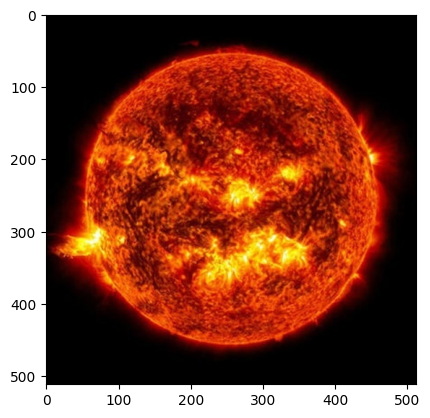

In [4]:
plt.imshow(sun)
print(sun.shape)

(512, 512, 3)


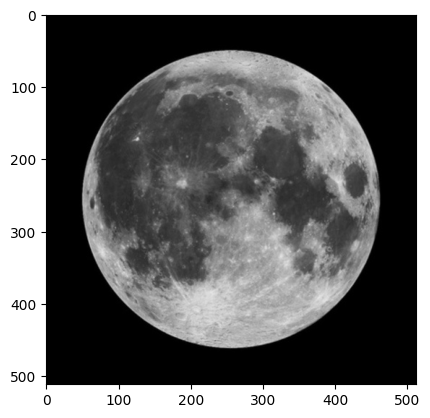

In [5]:
plt.imshow(moon)
print(moon.shape)

# Part A

In [20]:
def gaussian_pyramid(IMAGE, NUMLEVELS):
    G = IMAGE.copy()
    gp = [G]
    for i in range(1,NUMLEVELS):
        G = cv2.pyrDown(G)
        gp.append(G)
    return gp

def laplacian_pyramid(GP):
    numLevels = len(GP)-1
    lp  = [GP[numLevels]]
    for i in range(numLevels,0,-1):
        GE = cv2.pyrUp(GP[i])
        L = cv2.subtract(GP[i-1],GE)
        lp.append(L)
    lp = lp[::-1]
    return lp

# Pyramid levels
levels = 6

gpSun = gaussian_pyramid(sun,levels)
lpSun = laplacian_pyramid(gpSun)

gpMoon = gaussian_pyramid(moon,levels)
lpMoon = laplacian_pyramid(gpMoon)

for i in lpMoon:
    print(i.shape)

(512, 512, 3)
(256, 256, 3)
(128, 128, 3)
(64, 64, 3)
(32, 32, 3)
(16, 16, 3)


# Part B

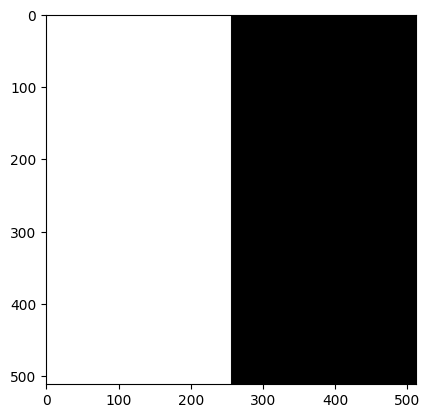

In [21]:
mask = np.concatenate((np.ones((512,256,3)),np.zeros((512,256,3))), axis=1)
plt.imshow(mask)

gpMask = gaussian_pyramid(mask,levels)
plt.imshow(mask)

# Part C

In [15]:
def laplacian_blend(SOURCE_LP, TARGET_LP, MASK_GP):
    # Number of pyramid levels
    numLevels = len(MASK_GP)

    # Normalize pyramids to 0-1
    #SOURCE_LP = normalize(SOURCE_LP)
    #TARGET_LP = normalize(TARGET_LP)
    #MASK_GP = normalize(MASK_GP)

    # Create blended pyramid
    blended_pyramid = [MASK_GP[0]*SOURCE_LP[0] + (1-MASK_GP[0])*TARGET_LP[0]]
    for i in range(1,numLevels):
        blended_pyramid.append(MASK_GP[i]*SOURCE_LP[i] + (1-MASK_GP[i])*TARGET_LP[i])
    
    # Collapse the blended pyramid
    scale = 2
    for levelIdx in range(numLevels-1,0,-1):
        upscaled_level = upsample(blended_pyramid[levelIdx],scale)
        blended_pyramid[levelIdx-1] = blended_pyramid[levelIdx-1] + upscaled_level
    blended_image = blended_pyramid[0]

    # Normalize blended image to 0-255
    blended_image = normalize(blended_image, 255).astype(int)
    
    return blended_image

In [18]:
red = np.full((8,8,3), 255, dtype='uint8')
red[:,0:1,0] = np.zeros((8,1))
red[:,:,1] = np.zeros((8,8))
red[:,:,2] = np.zeros((8,8))

blue = np.full((8,8,3), 255, dtype='uint8')
blue[:,7:,2] = np.zeros((8,1))
blue[:,:,0] = np.zeros((8,8))
blue[:,:,1] = np.zeros((8,8))

lpRed = laplacian_pyramid(gaussian_pyramid(red,3))
lpBlue = laplacian_pyramid(gaussian_pyramid(blue,3))

mask = np.concatenate((np.ones((8,4,3)),np.zeros((8,4,3))), axis=1)
gpMask = gaussian_pyramid(mask,3)

#plt.imshow(blue)

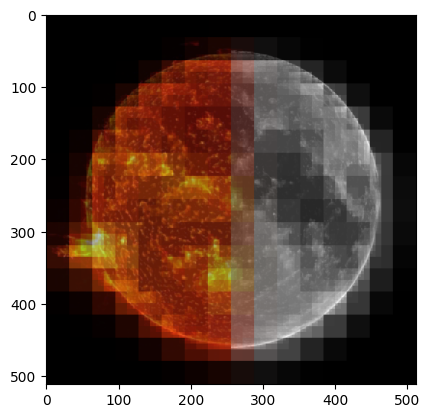

In [22]:
blended_image = laplacian_blend(lpSun,lpMoon,gpMask)
plt.imshow(blended_image)

# One Click Run